# PW1 - Handwritten character recognition


In [3]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Laure Zabar"
assert your_name

In [4]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [6]:
NUM_EPOCH = 2
BATCH_SIZE = 256

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [7]:
root_dir = './data/MNIST/'

### YOUR CODE HERE ###

train = torchvision.datasets.MNIST(root_dir, train=True, download=True, transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST(root_dir, train=False, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

In [8]:
### YOUR CODE HERE ###
print(f"Number of examples in training set: {len(train)}")
print(f"Number of examples in test set: {len(test)}")

Number of examples in training set: 60000
Number of examples in test set: 10000


The target is : 5
The input shape : torch.Size([1, 28, 28])


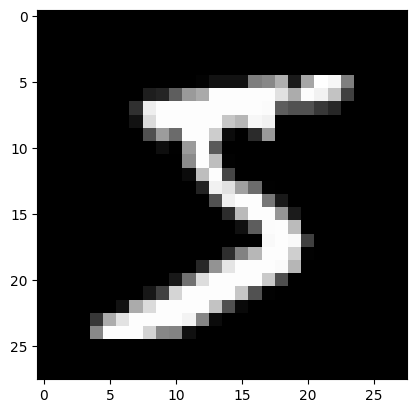

In [9]:
### YOUR CODE HERE ###
train_image, train_label = train[0]
plt.imshow(train_image[0], cmap = 'gray', interpolation="none") 
print(f"The target is : {train_label}")
print(f"The input shape : {train_image.shape}")

Vérification normalisation : 0.0 1.0
The target is : 6
The input shape : torch.Size([1, 28, 28])


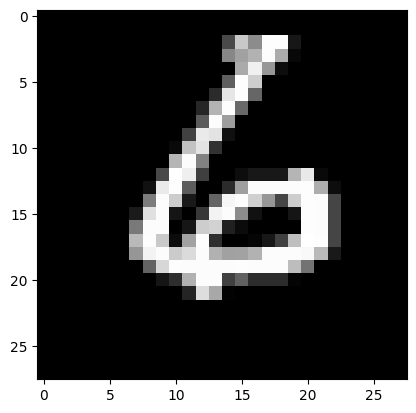

In [10]:
# avec ajout du train_dataloader
train_image, train_label = next(iter(train_dataloader))
print("Vérification normalisation :", train_image.min().item(), train_image.max().item())  

plt.imshow(train_image[0][0], cmap='gray', interpolation='none')
print(f"The target is : {train_label[0].item()}")
print(f"The input shape : {train_image[0].shape}")  

# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

In [11]:
### YOUR CODE HERE ###
def preprocess (image):
    return torch.nn.functional.avg_pool2d(image, kernel_size=4)

Vérification normalisatuon: 0.0 0.9921569228172302
The target is : 6
The input shape : torch.Size([7, 7])


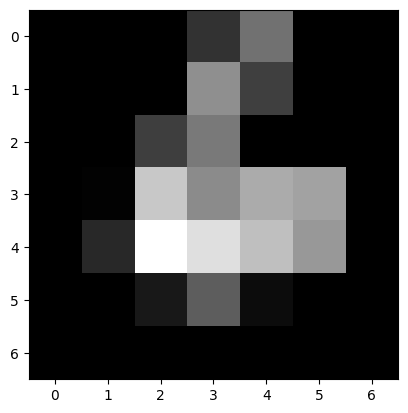

In [12]:
resize_image = preprocess(train_image)
print("Vérification normalisatuon:", resize_image.min().item(), resize_image.max().item())

plt.imshow(resize_image[0][0], cmap = 'gray', interpolation='none')
print(f"The target is : {train_label[0].item()}")
print(f"The input shape : {resize_image[0][0].shape}")

In [13]:
### YOUR ( MODEL / PREPROCESSING ) CODE HERE ###
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(49, 10) # 49 car on a downsampled à 7x7 && 10 classes de 0 à 9
    def forward(self, x): 
        x = x.flatten(start_dim=1)
        return self.linear(x)

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [14]:
### YOUR CODE HERE ###
loss = nn.CrossEntropyLoss()

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [15]:
def train(model, epoch, preprocess, optimizer):
    model.train()
    total, correct_pred = 0, 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        downsamp = preprocess(images) 
        outputs  = model(downsamp)
        loss_val = loss(outputs, labels)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct_pred += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct_pred / total
    print(f"Epoch {epoch+1} - Train Accuracy: {train_accuracy:.4f}")
    return optimizer, train_accuracy

def test(model, preprocess):
    model.eval()
    total, correct_pred = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            downsamp = preprocess(images)
            outputs = model(downsamp)
            preds = outputs.argmax(dim=1)
            correct_pred += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct_pred / total
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [16]:
### YOUR CODE HERE ###
model = LinearModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model, epoch, preprocess, optimizer)
    test_accuracy = test(model, preprocess)

Epoch 1 - Train Accuracy: 0.7623
Test Accuracy: 0.8458
Epoch 2 - Train Accuracy: 0.8436
Test Accuracy: 0.8583


In [ ]:
# test with another optimizer just to see how the behaviour changes
model = LinearModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model, epoch, preprocess, optimizer)
    test_accuracy = test(model, preprocess)

Epoch 1 - Train Accuracy: 0.8521
Test Accuracy: 0.8911
Epoch 2 - Train Accuracy: 0.8859
Test Accuracy: 0.8991


## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [17]:
class MLP(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.flatten(start_dim=1) 
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [19]:
model_mlp = MLP(input_size=49, hidden_size=100, output_size=10).to(device)
optimizer = torch.optim.SGD(model_mlp.parameters(), lr=1e-1, momentum=0.9)

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model_mlp, epoch, preprocess, optimizer)
    test_accuracy = test(model_mlp, preprocess)

Epoch 1 - Train Accuracy: 0.7425
Test Accuracy: 0.9000
Epoch 2 - Train Accuracy: 0.9061
Test Accuracy: 0.9265


# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [15]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Linear(8 * 13 * 13, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.flatten(start_dim=1)
        out = self.classifier(out)
        return out

In [16]:
model_cnn = ConvModel().to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-1, momentum=0.9)
preprocess = lambda x: x # il y a déjà un maxpool2d

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model_cnn, epoch, preprocess, optimizer)
    test_accuracy = test(model_cnn, preprocess)

Epoch 1 - Train Accuracy: 0.9100
Test Accuracy: 0.9580
Epoch 2 - Train Accuracy: 0.9681
Test Accuracy: 0.9733


In [37]:
NUM_EPOCH = 8

model_cnn = ConvModel().to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-1, momentum=0.9)
preprocess = lambda x: x # il y a déjà un maxpool2d

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model_cnn, epoch, preprocess, optimizer)
    test_accuracy = test(model_cnn, preprocess)

Epoch 1 - Train Accuracy: 0.9118
Test Accuracy: 0.9688
Epoch 2 - Train Accuracy: 0.9700
Test Accuracy: 0.9791
Epoch 3 - Train Accuracy: 0.9769
Test Accuracy: 0.9771
Epoch 4 - Train Accuracy: 0.9804
Test Accuracy: 0.9799
Epoch 5 - Train Accuracy: 0.9823
Test Accuracy: 0.9793
Epoch 6 - Train Accuracy: 0.9830
Test Accuracy: 0.9793
Epoch 7 - Train Accuracy: 0.9854
Test Accuracy: 0.9799
Epoch 8 - Train Accuracy: 0.9857
Test Accuracy: 0.9791


A slight overfitting is observed starting from the fourth epoch, as the training accuracy keeps increasing while the test accuracy plateaus around 97.9%.

You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [17]:
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(8 * 13 * 13, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 10)
        )

    def forward(self,x):
        out = self.layer1(x)
        out = out.flatten(start_dim=1)
        out = self.classifier(out)
        return out

In [ ]:
NUM_EPOCH = 2

model_deep_cnn = ConvDeepModel().to(device)
optimizer = torch.optim.SGD(model_deep_cnn.parameters(), lr=1e-1, momentum=0.9)
preprocess = lambda x: x

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model_deep_cnn, epoch, preprocess, optimizer)
    test_accuracy = test(model_deep_cnn, preprocess)

Epoch 1 - Train Accuracy: 0.7402
Test Accuracy: 0.9153
Epoch 2 - Train Accuracy: 0.9234
Test Accuracy: 0.9179


In [41]:
NUM_EPOCH = 8

model_deep_cnn = ConvDeepModel().to(device)
optimizer = torch.optim.SGD(model_deep_cnn.parameters(), lr=1e-1, momentum=0.9)
preprocess = lambda x: x

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model_deep_cnn, epoch, preprocess, optimizer)
    test_accuracy = test(model_deep_cnn, preprocess)

Epoch 1 - Train Accuracy: 0.8602
Test Accuracy: 0.9517
Epoch 2 - Train Accuracy: 0.9668
Test Accuracy: 0.9717
Epoch 3 - Train Accuracy: 0.9777
Test Accuracy: 0.9771
Epoch 4 - Train Accuracy: 0.9837
Test Accuracy: 0.9766
Epoch 5 - Train Accuracy: 0.9872
Test Accuracy: 0.9839
Epoch 6 - Train Accuracy: 0.9888
Test Accuracy: 0.9812
Epoch 7 - Train Accuracy: 0.9918
Test Accuracy: 0.9845
Epoch 8 - Train Accuracy: 0.9930
Test Accuracy: 0.9851


Compared to the simple convolutional model, the deeper convolutional model achieves a slightly higher test accuracy, reaching up to 98.5%. However, it also shows more signs of overfitting after several epochs, with training accuracy exceeding 99%. Overall, the deeper model provides better learning capacity but also requires careful monitoring to avoid overfitting.

## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

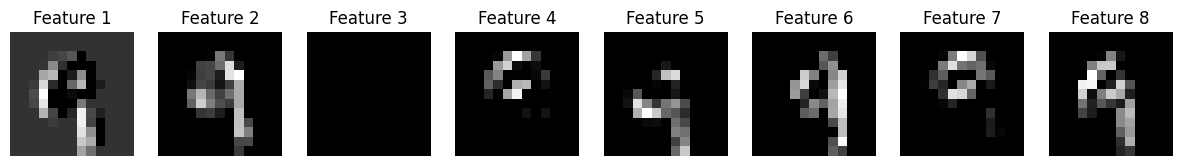

In [23]:
### YOUR CODE HERE ###
images, labels = next(iter(test_dataloader))

image = images[0].unsqueeze(0).to(device)

with torch.no_grad():
    cnn_out = model_cnn.layer1(image)

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(cnn_out[0, i].cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Feature {i+1}")
plt.show()

#### pas le bon plot, essai avec une modification du simple conv model

In [21]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.layer1 = nn.Conv2d(1, 8, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.classifier = nn.Linear(8 * 13 * 13, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.pool(out)
        out = out.flatten(start_dim=1)
        out = self.classifier(out)
        return out

In [23]:
NUM_EPOCH = 2

model_cnn = ConvModel().to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-1, momentum=0.9)
preprocess = lambda x: x # il y a déjà un maxpool2d

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model_cnn, epoch, preprocess, optimizer)
    test_accuracy = test(model_cnn, preprocess)

Epoch 1 - Train Accuracy: 0.9053
Test Accuracy: 0.9640
Epoch 2 - Train Accuracy: 0.9691
Test Accuracy: 0.9741


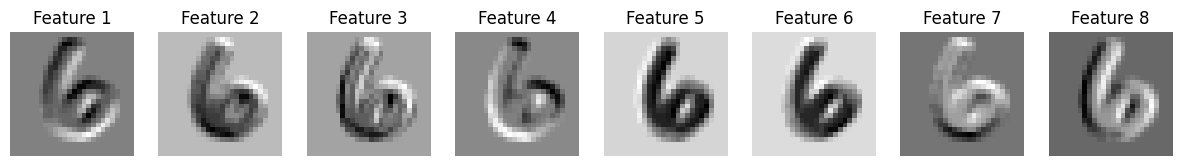

In [25]:
### YOUR CODE HERE ###
images, labels = next(iter(test_dataloader))

image = images[0].unsqueeze(0).to(device)

with torch.no_grad():
    cnn_out = model_cnn.layer1(image)

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(cnn_out[0, i].cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Feature {i+1}")
plt.show()

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        ### YOUR CODE HERE ###
        self.layer1 = nn.Linear(d, h)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(h, d)

    def forward(self,x):
        ### YOUR CODE HERE ###
        x = x.view(x.size(0), -1)
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out += x
        return out

In [19]:
class ResidualConvBlock(nn.Module):
    def __init__(self, d, h):
        super(ResidualConvBlock, self).__init__()
        self.layer1 = nn.Conv2d(d, h, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Conv2d(h, d, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out += x
        return self.relu(out)

In convolutional blocks, the number of output channels (i.e., the number of filters) plays the same role as the number of hidden neurons in fully connected layers, as it controls the capacity of the model to extract and represent features.

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [20]:
class ResidualModel(nn.Module):
    def __init__(self, l, h, k=3, out=8):
        super().__init__()
        self.layer1 = nn.Conv2d(1, h, kernel_size=k, padding=k//2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        blocks = [ResidualConvBlock(h, h) for _ in range(l)]
        self.res = nn.Sequential(*blocks)
        self.classifier = nn.Linear(h * 14 * 14, out)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.res(x)
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

In [21]:
model_res = ResidualModel(l=3, h=32, out=10).to(device)
optimizer = torch.optim.SGD(model_res.parameters(), lr=1e-1, momentum=0.9)
preprocess = lambda x: x

for epoch in range(NUM_EPOCH):
    optimizer, train_accuracy = train(model_res, epoch, preprocess, optimizer)
    test_accuracy = test(model_res, preprocess)

Epoch 1 - Train Accuracy: 0.9366
Test Accuracy: 0.9849
Epoch 2 - Train Accuracy: 0.9850
Test Accuracy: 0.9840


# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [24]:
### YOUR CODE HERE ###

## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [25]:
def ce(logits, targets):
    ### YOUR CODE HERE ###
    pass

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [26]:
### YOUR CODE HERE ###

Re-implement a stable version of cross-entropy.

In [27]:
def stable_ce(logits, targets):
    ### YOUR CODE HERE ###
    pass